In [1]:
import torch
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.training.configs.training_configs import ProcessDatasetConfig
from pathlib import Path
import json

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_path = Path("/workspaces/cure/compmech-models/models/f6gnm1we-mess3-0.15-0.6/")
weights = torch.load(checkpoint_path / "998406400.pt")
device = torch.device("cuda:1")

In [3]:
with open(checkpoint_path / "train_config.json", "r") as f:
    required_fields = ['d_vocab', 'd_model', 'n_ctx', 'd_head', 'n_heads', 'n_layers']
    cfg_dict = {k: v for k, v in json.load(f).items() if k in required_fields}
    cfg_dict['n_head'] = cfg_dict.pop('n_heads')
    cfg_dict['d_mlp'] = 4 * cfg_dict['d_model']
    train_config = RawModelConfig(**cfg_dict)

model = train_config.to_hooked_transformer(device=device)
model.load_state_dict(weights)

<All keys matched successfully>

In [4]:
dataset_config = ProcessDatasetConfig(
    process='Mess3',
    process_params={'x': 0.5, 'a': 0.85},
    batch_size=512,
    num_tokens=500000,
    test_split=0.05
)

train_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=True)
test_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=False)

In [5]:
from epsilon_transformers.process.processes import Mess3
mess3 = Mess3()
msp_tree = mess3.derive_mixed_state_presentation(depth=model.cfg.n_ctx + 1)


In [6]:
tree_paths, tree_beliefs = msp_tree.paths_and_belief_states

transformer_inputs = [x for x in tree_paths if len(x) == train_config.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to("cuda:1")

In [7]:
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)


In [11]:
transformer_input_beliefs.shape

torch.Size([59049, 10, 3])

<class 'numpy.ndarray'>
(59049, 10, 3)


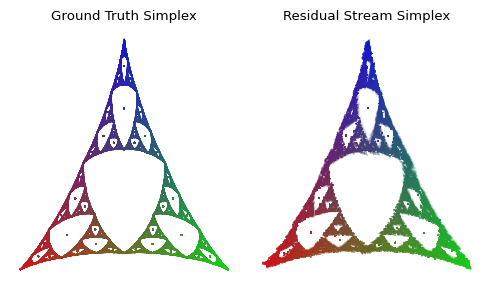

In [32]:
from sklearn.linear_model import LinearRegression

_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    print(type(activations))
    activations_flattened = activations.reshape(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.reshape(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions

acts = activations['blocks.3.hook_resid_post'].cpu().detach().numpy()
# transformer_input_beliefs = transformer_input_beliefs.cpu().detach().numpy()
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(belief_predictions.shape)



from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt
import seaborn as sns


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened#.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()



In [24]:
type(acts)

numpy.ndarray

# Linear probe training

In [71]:
from transformer_lens.hook_points import HookPoint
from torch.optim import Adam, Optimizer
from torch import nn
import numpy as np
from functools import partial

class LinearProbe(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, dtype=torch.float32)
    def forward(self, residual_stream: torch.Tensor):
        return self.linear(residual_stream)

linear_probe = LinearProbe(64, 3).cuda()
optimizer = Adam(linear_probe.parameters())
loss_fn = nn.MSELoss()


In [72]:
def probe_train_hook(attn_result: torch.Tensor, hook: HookPoint, beliefs: torch.Tensor) -> torch.Tensor:
    optimizer.zero_grad()
    probe_out = linear_probe(attn_result)
    loss = loss_fn(input=probe_out, target=beliefs)
    loss.backward()
    optimizer.step()

    print(loss)

    return attn_result

def probe_test_hook(attn_result: torch.Tensor, hook: HookPoint, beliefs: torch.Tensor) -> torch.Tensor:
    optimizer.zero_grad()
    probe_out = linear_probe(attn_result)
    loss = loss_fn(input=probe_out, target=beliefs)
    # print(loss)

    return attn_result

from typing import List
def probe_log_hook(attn_result: torch.Tensor, hook: HookPoint, belief_guess_list: List) -> torch.Tensor:
    probe_out = linear_probe(attn_result)
    belief_guess_list.append(probe_out)
    return attn_result

In [73]:
train_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=True)
for inputs, labels in train_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_train_hook, beliefs=beliefs)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

tensor(1.5391, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3298, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1331, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9829, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8492, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7254, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6384, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5340, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4594, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3991, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3310, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2843, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2428, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2044, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1761, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1574, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1433, device='cuda:0', grad_fn=

In [9]:
for inputs, labels in test_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_test_hook, beliefs=beliefs)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

In [74]:
test_loader = dataset_config.to_dataloader(sequence_length=cfg_dict["n_ctx"], train=False)

belief_guess_list = []
for inputs, labels in test_loader:
    beliefs = torch.tensor(
        np.stack([msp_tree.path_to_beliefs(list(input)) for input in inputs]),
        device=torch.device("cuda"),
        dtype=torch.float32
    )
    hook_with_beliefs = partial(probe_log_hook, belief_guess_list=belief_guess_list)
    inputs = inputs.to("cuda")
    _ = model.run_with_hooks(inputs, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])

In [75]:
points = torch.cat(belief_guess_list)
points = points.view(points.shape[0]*points.shape[1], points.shape[2])

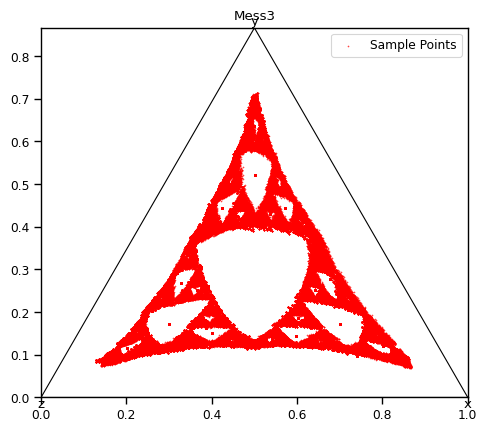

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to convert ternary coordinates to Cartesian coordinates
def ternary_to_cartesian(triples):
    points = []
    for triple in triples:
        x = 0.5 * (2 * triple[1] + triple[2])
        y = (np.sqrt(3) / 2) * triple[2]
        points.append([x, y])
    return np.array(points)

# Convert ternary coordinates to Cartesian coordinates
ternary_points = ternary_to_cartesian(belief_predictions_flattened)#points.cpu().detach().numpy())

# Plotting
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, np.sqrt(3) / 2)

# Draw the triangle
triangle = plt.Polygon([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]], edgecolor='k', fill=None)
ax.add_patch(triangle)

# Plot points
ax.scatter(ternary_points[:, 0], ternary_points[:, 1], color='red', label='Sample Points',s=0.1)

# Add labels
ax.text(0, 0, 'z', ha='center', va='top')
ax.text(1, 0, 'x', ha='center', va='top')
ax.text(0.5, np.sqrt(3) / 2, 'y', ha='center', va='bottom')

# Show plot
plt.title("Mess3")
plt.legend()
plt.show()


In [19]:
import itertools
import torch

def generate_all_sequences(int_set, sequence_length):
    # Generate all possible sequences
    sequences = list(itertools.product(int_set, repeat=sequence_length))
    
    # Convert the list of sequences to a PyTorch tensor
    tensor_sequences = torch.tensor(sequences, dtype=torch.int)
    
    return tensor_sequences

# Example usage
int_set = [0, 1, 2]  # The specific set of integers
sequence_length = 10  # The specified length of the sequences

all_seqs = generate_all_sequences(int_set, sequence_length)

In [23]:
residual_streams = []
def fwd_cache_hook(attn_result: torch.Tensor, hook: HookPoint) -> torch.Tensor:
    residual_streams.append(attn_result)
    return attn_result

for idx, seq in enumerate(all_seqs):
    _ = model.run_with_hooks(inputs, fwd_hooks=[
        ('blocks.3.hook_resid_post', fwd_cache_hook)
    ])
    if idx % 100 == 0:
        print(idx)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


KeyboardInterrupt: 